# Sentiment Dataset Overview

This notebook provides basic exploratory analysis of a sentiment dataset and prepare it for Natural Language Processing (NLP) tasks.

---

## Table of Contents

1. [Imports](#imports)
2. [Examining class distribution)](#examining-class-distribution)
3. [Text length analysis)](#text-length-analysis)
4. [Analysis of the most frequently occurring words](#analysis-of-the-most-frequently-occurring-words)
5. [Saving to file](#saving-to-file)

# Imports

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Examining class distribution

In [4]:
sentiment_df = pd.read_parquet('sentiment/sentiment_dataset.parquet')

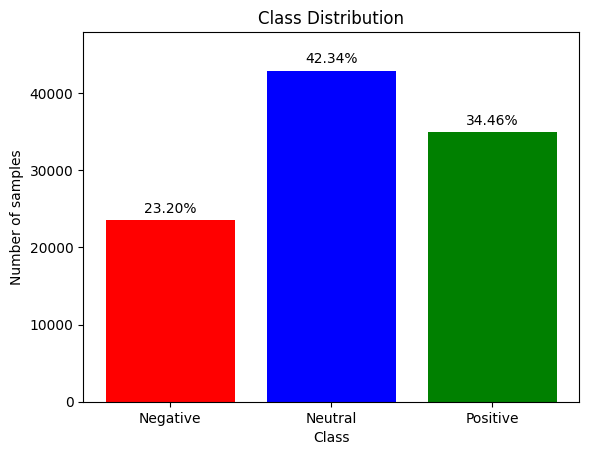

In [12]:
class_counts = sentiment_df['label'].value_counts()
class_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
class_percentages = (class_counts / class_counts.sum()) * 100

class_counts_dict = {class_labels[key]: class_counts[key] for key in class_labels.keys()}
class_percentages_dict = {class_labels[key]: class_percentages[key] for key in class_labels.keys()}

plt.bar(class_counts_dict.keys(), class_counts_dict.values(), color=['red', 'blue', 'green'])

for label, count in class_counts_dict.items():
    percentage = f'{class_percentages_dict[label]:.2f}%'
    plt.text(list(class_counts_dict.keys()).index(label), count + 1000, percentage, ha='center')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.ylim(0, class_counts.max() + 5000)
plt.show()

The dataset has an imbalanced distribution, with the "Neutral" class comprising the largest proportion (42.34%), followed by "Positive" (34.46%) and "Negative" (23.20%).

For training NLP models, this imbalance can lead to biased predictions favoring the majority class ("Neutral") while underrepresenting the minority class ("Negative"). To address this issue, class weighting will be applied during model training.

# Text length analysis

In [13]:
sentiment_df['text_length'] = sentiment_df['text'].apply(len)

In [14]:
sentiment_df['text_length'].describe()

count    101269.000000
mean         96.139806
std          63.871903
min           4.000000
25%          61.000000
50%          93.000000
75%         116.000000
max        2144.000000
Name: text_length, dtype: float64

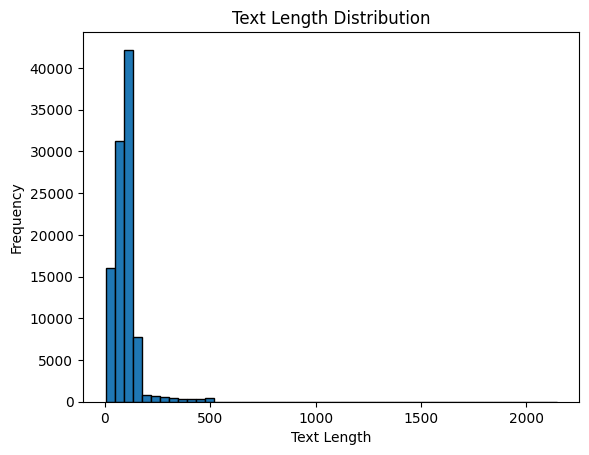

In [16]:
plt.hist(sentiment_df['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

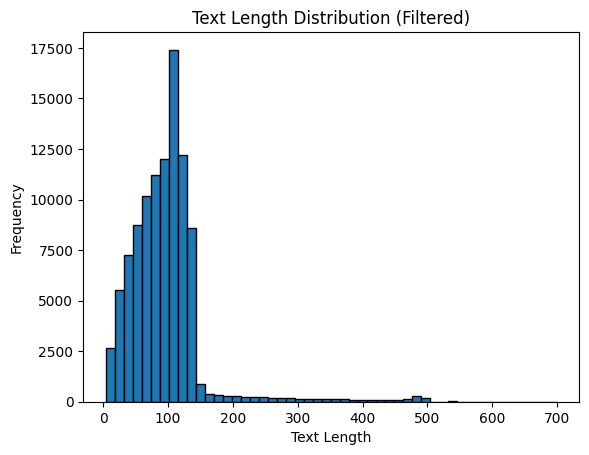

In [18]:
plt.hist(sentiment_df[sentiment_df['text_length'] < 700]['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution (Filtered)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Some texts are of considerable length (which may affect the setting of the maximum token length). There is a need to remove outliers.

Text length column - LB: -21.5   UB: 198.5


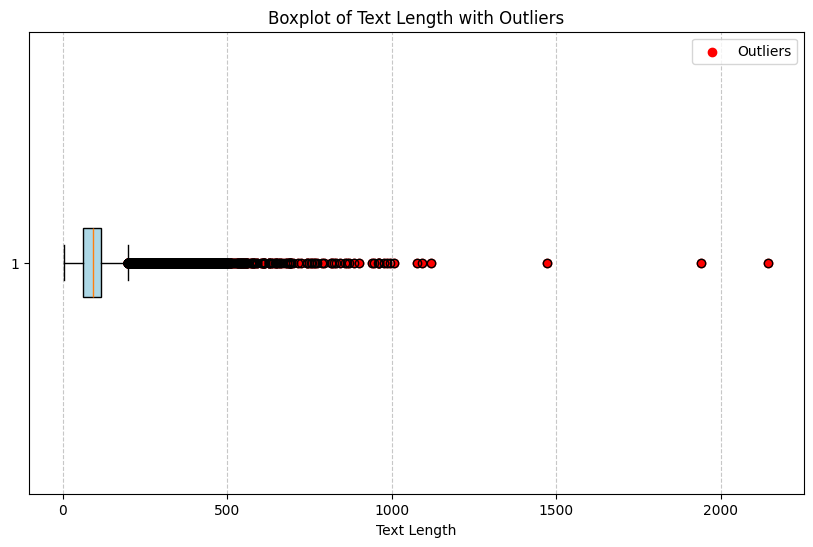

Outliers:
                                                     text  label  text_length
77      Very useful app if you are in the habit of for...      1          334
84      I missed my work today because of your stupid ...      0          556
89      good app, but not what im looking for. id like...      2          283
96      Does everything it says it does. I use it on m...      2          257
117     I am a long time user and lover of Wunderlis, ...      1          473
...                                                   ...    ...          ...
101140  App still needs a lot of work. Its not at the ...      1          367
101188  I personally would like to add to this app, if...      1          303
101191  Pagu por la versin premium y ahora igualmente ...      0          249
101211  I really love the app, I use it a lot while st...      2          334
101237  It WAS really great until I bought my Samsung ...      1          254

[3596 rows x 3 columns]


In [28]:
q1 = sentiment_df['text_length'].quantile(0.25)
q3 = sentiment_df['text_length'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = sentiment_df[(sentiment_df['text_length'] < lower_bound) |
                        (sentiment_df['text_length'] > upper_bound)]

print(f'Text length column - LB: {lower_bound}   UB: {upper_bound}')

plt.figure(figsize=(10, 6))
plt.boxplot(sentiment_df['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.scatter(outliers['text_length'], [1] * len(outliers), color='red', label='Outliers')

plt.title('Boxplot of Text Length with Outliers')
plt.xlabel('Text Length')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Outliers:\n{outliers}")

### In the context of training NLP models, I've decided to remove outliers where the text length exceeds the 256 token length.

In [29]:
sentiment_df = sentiment_df[sentiment_df['text_length'] <= 256]

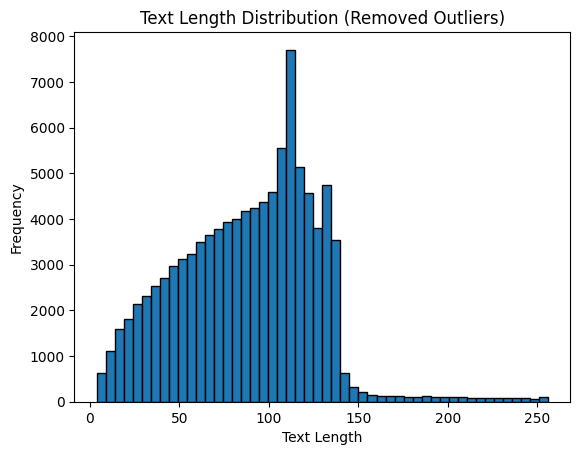

In [30]:
plt.hist(sentiment_df['text_length'], bins=50, edgecolor='black')
plt.title("Text Length Distribution (Removed Outliers)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Text length column - LB: -22.5   UB: 197.5


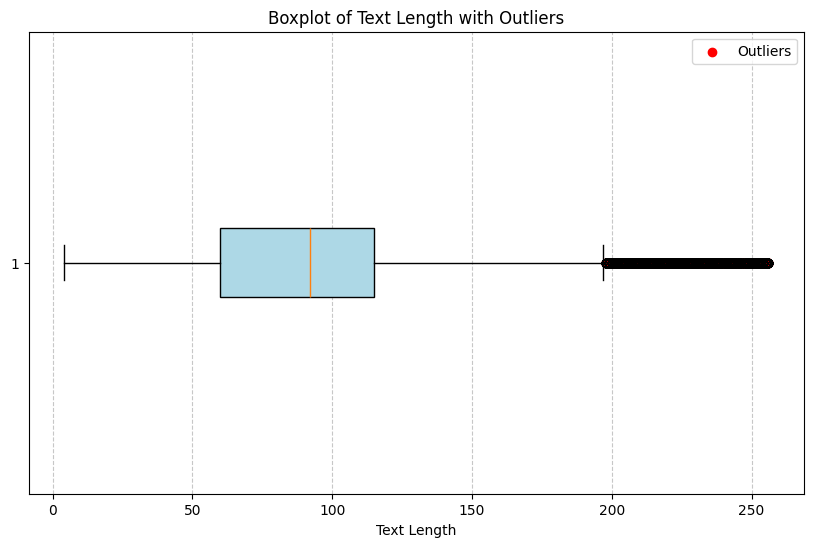

Outliers:
                                                     text  label  text_length
157     Repeat function doesnt work, so you cant set u...      0          235
330     Great app! Todoist will send reminders that I ...      2          247
339     the reviews are sending a clear message to you...      1          205
569     Amazing app. Very helpful in planning your bus...      2          229
652     Very good app but something lacl There is opti...      1          243
...                                                   ...    ...          ...
100939  This is by far the most useful and customisabl...      2          244
100972  Nice application you can update everyday... Th...      2          238
101011  First time and first day was everyting amazing...      1          239
101191  Pagu por la versin premium y ahora igualmente ...      0          249
101237  It WAS really great until I bought my Samsung ...      1          254

[1006 rows x 3 columns]


In [31]:
q1 = sentiment_df['text_length'].quantile(0.25)
q3 = sentiment_df['text_length'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = sentiment_df[(sentiment_df['text_length'] < lower_bound) |
                        (sentiment_df['text_length'] > upper_bound)]

print(f'Text length column - LB: {lower_bound}   UB: {upper_bound}')

plt.figure(figsize=(10, 6))
plt.boxplot(sentiment_df['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.scatter(outliers['text_length'], [1] * len(outliers), color='red', label='Outliers')

plt.title('Boxplot of Text Length with Outliers')
plt.xlabel('Text Length')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Outliers:\n{outliers}")

# Analysis of the most frequently occurring words

In [34]:
all_words = ' '.join(sentiment_df['text']).split()
word_freq = Counter(all_words)

In [35]:
print("Ten most common words:", word_freq.most_common(10))

Ten most common words: [('the', 55480), ('to', 41315), ('I', 27458), ('a', 25659), ('and', 23291), ('in', 20734), ('of', 18561), ('on', 18137), ('is', 18037), ('for', 17927)]


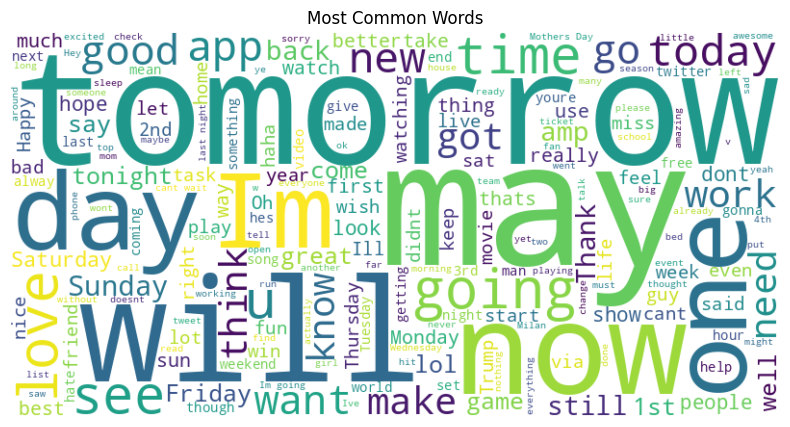

In [36]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words")
plt.show()

The WordCloud visualization highlights the most frequently occurring words in the dataset. Common words like "tomorrow," "day," "may," and "will" dominate the text. However, many of these words might not provide meaningful insights due to their generic nature as "stop words" (these words do affect the training of the model, so they will not be removed from the dataset).

In [38]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [39]:
all_words = ' '.join(sentiment_df['text']).split()
filtered_words = [word for word in all_words if word.lower() not in stop_words]

word_freq = Counter(filtered_words)

In [40]:
print("Ten most common words (excluding stop words):", word_freq.most_common(10))

Ten most common words (excluding stop words): [('may', 6054), ('Im', 5096), ('like', 4925), ('tomorrow', 4711), ('get', 4337), ('going', 4113), ('see', 3751), ('day', 3700), ('time', 3267), ('go', 3171)]


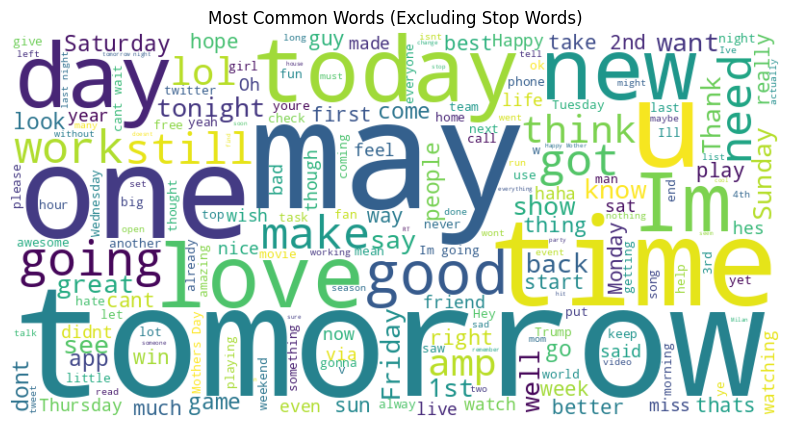

In [41]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words (Excluding Stop Words)")
plt.show()

The data was previously cleaned at an earlier stage.

# Saving to file

In [42]:
sentiment_df.to_csv(
    'sentiment_without_outliers/sentiment_without_outliers.csv',
    index=False,
    sep=',',
    encoding='utf-8'
)

sentiment_df.to_parquet(
    'sentiment_without_outliers/sentiment_without_outliers.parquet',
    index=False,
)